# Time model 

The court is cut into different cell. For each cell, we would like to know the closest player taking into account inertia. Mathematical development are avalaible in the file *Closest_player_to_a_point*. Here we the results of this model, particularly, how visually we can see that it takes inertia into account

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import json
import space as sp
from data_extracter import json_extracter
import pandas as pd

data,events=json_extracter('data/game1.json')

## Function Time_to_point
This function returns the time required to go from point a to point b with initial speed v. F is the value of the force granted to a player (per unit of mass). A previous investigation has told that F should be closed to 10m/s [1].

In [2]:
def time_to_point(a,b,v,F=10*3.28):   
    "time to go from a to b with initial speed v, F is the force parameter in feet/s-2"
    x0,y0=a
    xf,yf=b
    X=x0-xf
    Y=y0-yf
    k4=1
    k3=0
    k2=4*(v[0]**2+v[1]**2)/F**2
    k1=8*(v[0]*X+v[1]*Y)/F**2
    k0=4*(X**2+Y**2)/F**2
    times=np.roots([k4,k3,-k2,-k1,-k0])
    for i in range(4):                      # Selection of the root real and positive
        if times[i].imag==0:
            if times[i]>0:
                return times[i].real
    print('error')
    return times[0]

## Example of trajectories with our model

The black arrow represents the force and the green arrow the initial speed. 

In [3]:
def path(a,b,v,F=10*3.28,nb_points=100):
    tf=time_to_point(a,b,v,F)
    Fx=2*(b[0]-a[0]-v[0]*tf)/tf**2
    Fy=2*(b[1]-a[1]-v[1]*tf)/tf**2
    dt=tf/nb_points
    t=dt
    lx=[a[0]]
    ly=[a[1]]
    for i in range(nb_points):
        x=a[0]+v[0]*t+Fx*t**2/2
        y=a[1]+v[1]*t+Fy*t**2/2
        lx.append(x)
        ly.append(y)
        t=t+dt
    return(lx,ly,Fx,Fy,tf)

In [4]:
def print_path(a,b,v,F=10*3.28):
    lx,ly,Fx,Fy,tf=path(a,b,v,F)
    plt.plot(lx,ly)
    plt.plot(a[0],a[1], 'ro')
    plt.plot(b[0],b[1], 'bo')
    plt.arrow(a[0],a[1],Fx/10,Fy/10,shape='full',lw=1.5,head_width=0.2)
    plt.arrow(a[0],a[1],v[0],v[1],shape='full',lw=1.5,head_width=0.2, color='g')
    plt.xlim(min(v[0],Fx/10,0)-2,max(v[0],Fx/10,0)+2)
    plt.ylim(min(v[1],Fy/10,0)-2,max(v[1],Fy/10,0)+2)
    plt.show()

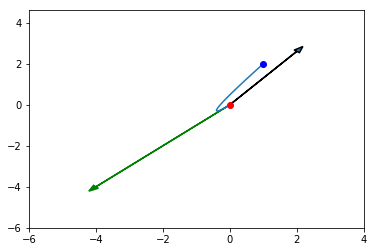

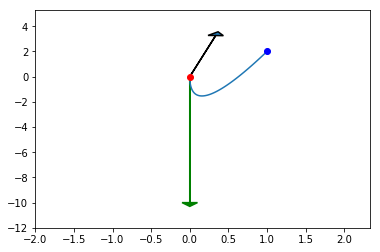

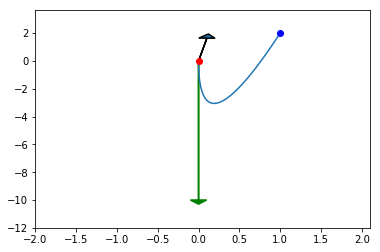

In [5]:
plt.subplots()
print_path(np.array([0,0]),np.array([1,2]),np.array([-4,-4]))
print_path(np.array([0,0]),np.array([1,2]),np.array([0,-10]))
print_path(np.array([0,0]),np.array([1,2]),np.array([0,-10]),F=5*3.28)

## Comparing our trajectories to real ones

The aim is to adjust the value of F. We take the position $a$ of a player at a time t. We look where he is (point $b$) at the time t+$\Delta$t and the trajectory he made during $\Delta$t. With our model, we compute the trajectory to go from $a$ to $b$ and look at the difference between both trajectories. We iterate several time and we do this for several value of F. Then, we can adjust our F value to the one that leads to less errors.

In [6]:
def one_trajectory_error(lx,ly,lxreal,lyreal):
    MSE=0
    for x,y,xreal,yreal in zip(lx,ly,lxreal,lyreal):
        delta=(np.linalg.norm(np.array([xreal-x,yreal-y])))**2
        MSE+=delta
    return MSE
    

In [7]:
def players_ball_speed_position(moment1,moment2):
    team1,team2,ball =[],[],[]
    
    dt=0.04
    mom_infos={}
    mom_infos['ball']={}
    mom_infos['team1']={}
    mom_infos['team2']={}
    for i in range(11) :
        if i==0:
            mom_infos['ball']['xy']=np.array(moment1[i][2:4])
            mom_infos['ball']['z']=moment1[i][4]
            mom_infos['ball']['v']=np.array([(moment2[i][2]-moment1[i][2])/dt,(moment2[i][3]-moment1[i][3])/dt])
        if 6<=i<=11:
            mom_infos['team2'][str(moment1[i][1])]={'xy':np.array(moment1[i][2:4]),'v':np.array([(moment2[i][2]-moment1[i][2])/dt,(moment2[i][3]-moment1[i][3])/dt])}
        if 1<=i<=5:
            mom_infos['team1'][str(moment1[i][1])]={'xy':np.array(moment1[i][2:4]),'v':np.array([(moment2[i][2]-moment1[i][2])/dt,(moment2[i][3]-moment1[i][3])/dt])}
    return(mom_infos)

In [65]:
def event_trajectory_error(eventId,t):
    event=events[eventId]
    moments=event['moments']
    forces=[]
    errors=[]
    times=[]
    for f in np.arange(3,15,0.5):
        error=[]
        TF=[]
        for mom_id in range(len(moments)-round(t/0.04)-1):
            err=0
            moment1=moments[mom_id][5]
            moment2=moments[mom_id+1][5]
            moment1f=moments[mom_id+round(t/0.04)][5]
            moment2f=moments[mom_id+round(t/0.04)+1][5]
            mom_infos=players_ball_speed_position(moment1,moment2)
            mom_infos_final=players_ball_speed_position(moment1f,moment2f)
            LX={}
            LY={}
            LXREAL={}
            LYREAL={}
            
            for player in mom_infos['team1'].keys():
                a=mom_infos['team1'][player]['xy']
                v=mom_infos['team1'][player]['v']
                b=mom_infos_final['team1'][player]['xy']
                lx,ly,Fx,Fy,tf=path(a,b,v,f*3.28,round(t/0.04))
                LX[player]=lx
                LY[player]=ly
                TF.append(tf-t)
            
            for player in mom_infos['team2'].keys():
                a=mom_infos['team2'][player]['xy']
                v=mom_infos['team2'][player]['v']
                b=mom_infos_final['team2'][player]['xy']
                lx,ly,Fx,Fy,tf=path(a,b,v,f*3.28,round(t/0.04))
                LX[player]=lx
                LY[player]=ly
                TF.append(tf-t)
            
            for player in mom_infos['team1'].keys():
                LXREAL[player]=[]
                LYREAL[player]=[]
            
            for player in mom_infos['team2'].keys():
                LXREAL[player]=[]
                LYREAL[player]=[]
            
            for i in range(round(t/0.04)+1):
                mom1=moments[mom_id+i][5]
                mom2=moments[mom_id+i+1][5]
                mom_infos=players_ball_speed_position(mom1,mom2)
                for player in mom_infos['team1'].keys():
                    LXREAL[player].append(mom_infos['team1'][player]['xy'][0])
                    LYREAL[player].append(mom_infos['team1'][player]['xy'][1])
                
                for player in mom_infos['team2'].keys():
                    LXREAL[player]=LXREAL[player]+[mom_infos['team2'][player]['xy'][0]]
                    LYREAL[player]=LYREAL[player]+[mom_infos['team2'][player]['xy'][1]]
            
            for player in LX.keys():
                if one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player])>0.2 and f==10:
                    print('f:',f)
                    print(LX[player][-1],LXREAL[player][-1])
                    print(one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player]))
                    plt.plot(LX[player],LY[player],'b-o')
                    plt.plot(LXREAL[player],LYREAL[player],'r-o')
                    plt.show()
                error.append(one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player]))

        errors.append(error)
        forces.append(f)
        times.append(TF)
    return(errors,forces,times)
        
            
        

f: 10.0
12.99364 12.99364
0.52319564365


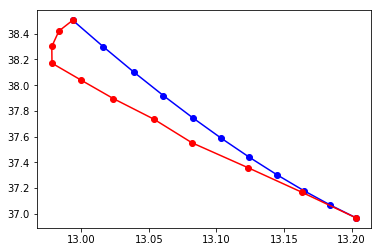

f: 10.0
14.2052 14.2052
0.234756192328


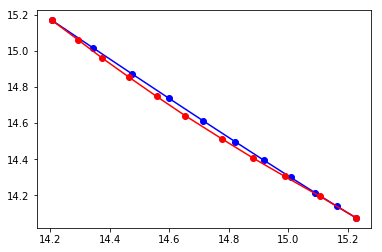

f: 10.0
14.40726 14.40726
0.298216314669


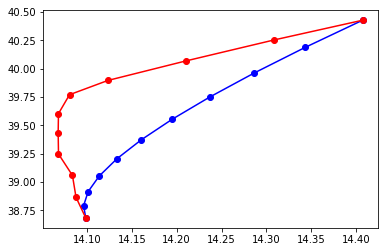

f: 10.0
13.0218 13.0218
0.495433398941


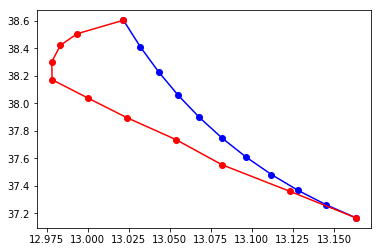

f: 10.0
14.12416 14.12416
0.231409236336


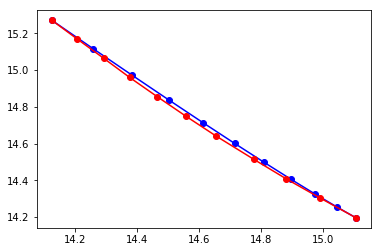

f: 10.0
14.49279 14.49279
0.242969102699


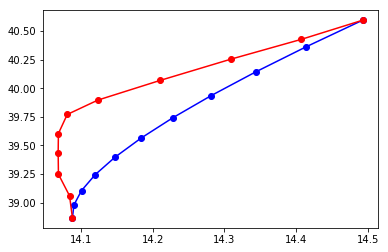

f: 10.0
30.57015 30.57015
0.224733997284


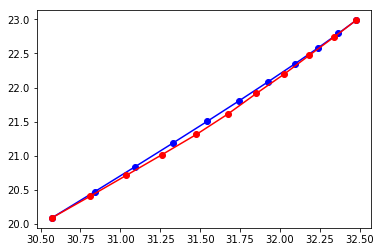

f: 10.0
13.0679 13.0679
0.443464381847


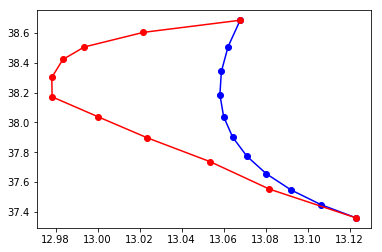

f: 10.0
14.04648 14.04648
0.239657761189


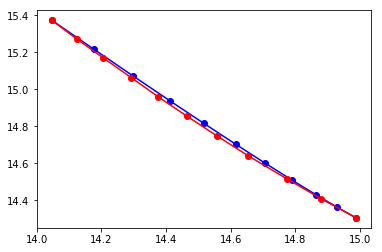

f: 10.0
30.32487 30.32487
0.249933824154


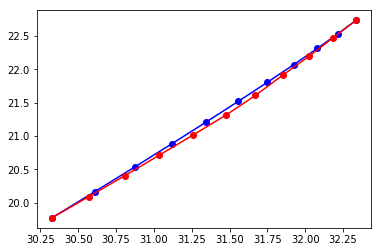

f: 10.0
13.12777 13.12777
0.407618250959


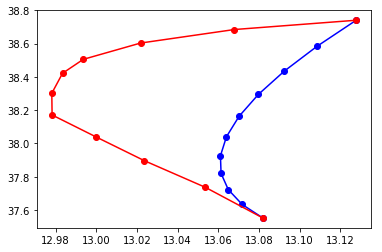

f: 10.0
13.9692 13.9692
0.249130093673


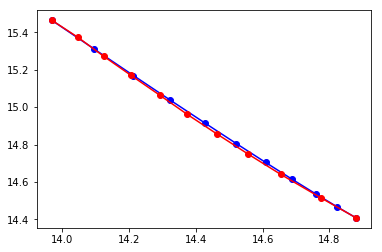

f: 10.0
30.06139 30.06139
0.254212039445


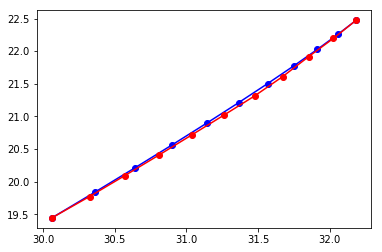

f: 10.0
13.18695 13.18695
0.356362154393


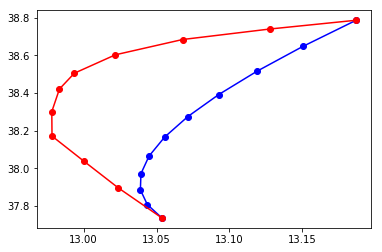

f: 10.0
13.89116 13.89116
0.206727738621


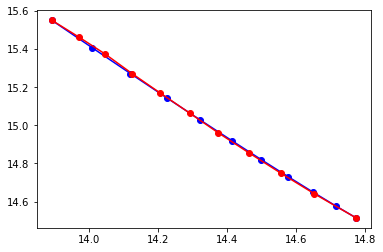

f: 10.0
29.78729 29.78729
0.271300246674


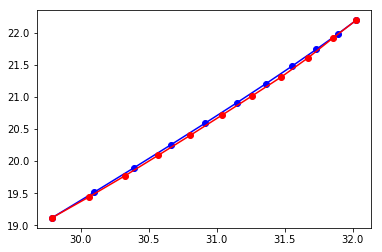

f: 10.0
13.26184 13.26184
0.344663992415


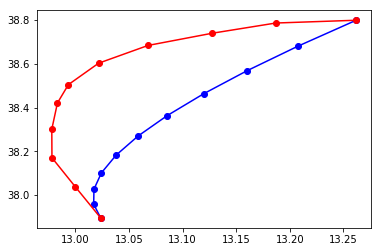

f: 10.0
13.82023 13.82023
0.209190589361


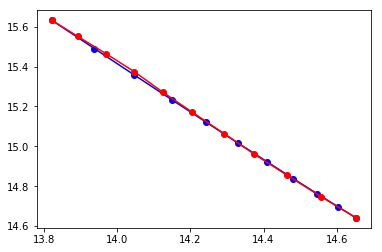

f: 10.0
14.84365 14.84365
0.233334498746


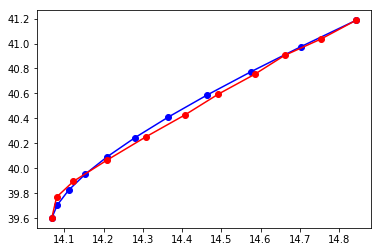

f: 10.0
29.49515 29.49515
0.242489523149


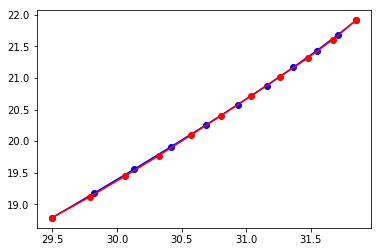

f: 10.0
13.32714 13.32714
0.319240792574


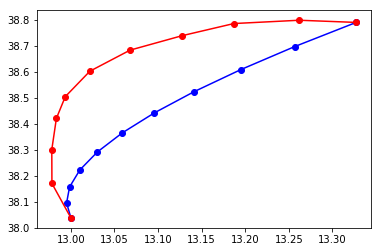

f: 10.0
13.75491 13.75491
0.218592596377


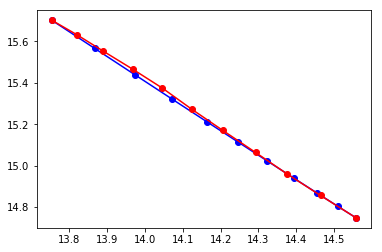

f: 10.0
14.93089 14.93089
0.388619893786


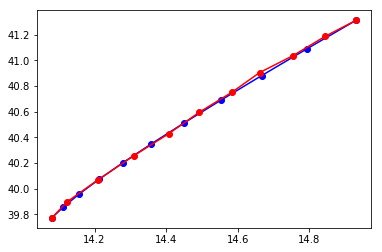

f: 10.0
29.19481 29.19481
0.263621939772


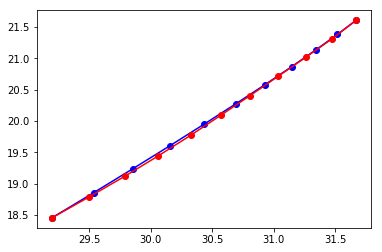

f: 10.0
13.39261 13.39261
0.28010989414


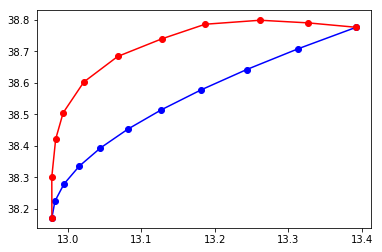

f: 10.0
13.69923 13.69923
0.23408125672


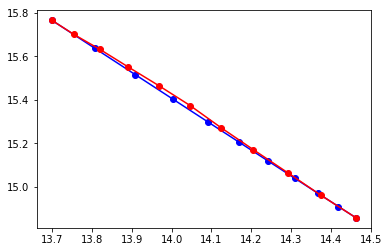

f: 10.0
14.99766 14.99766
0.428896973135


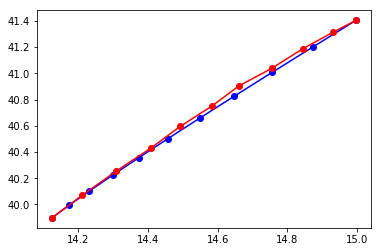

f: 10.0
28.8897 28.8897
0.262191086672


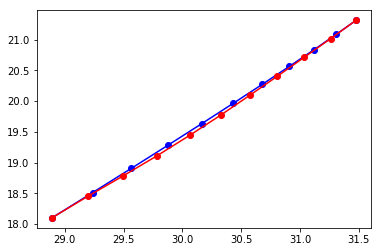

f: 10.0
13.43911 13.43911
0.226854487794


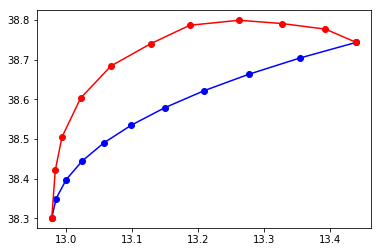

f: 10.0
13.65134 13.65134
0.254733062837


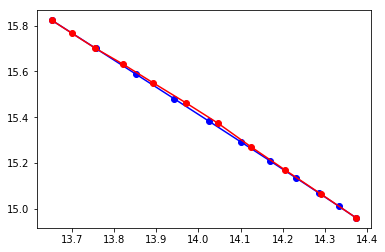

f: 10.0
15.08441 15.08441
0.422869688512


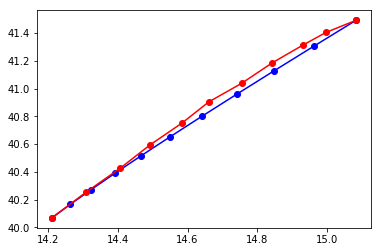

f: 10.0
28.57051 28.57051
0.26826604445


KeyboardInterrupt: 

In [66]:
errors,forces,times=event_trajectory_error(0,0.4)

In [10]:
df=pd.DataFrame(errors,index=forces)
df.T.describe()

,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,...,10.0,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5
count,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,...,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000
mean,6.964169,3.551456,1.720065,0.734300,0.170184,0.125682,0.134813,0.144744,0.154084,0.163314,...,0.204408,0.211970,0.219336,0.226516,0.233518,0.240350,0.247018,0.253529,0.259890,0.266107
std,25.117158,14.292526,7.863131,3.829288,0.847611,0.139406,0.148142,0.157644,0.166789,0.176196,...,0.219569,0.227936,0.236198,0.244352,0.252399,0.260339,0.268171,0.275896,0.283514,0.291027
min,0.000523,0.000553,0.000225,0.000324,0.000678,0.000732,0.000778,0.000823,0.000866,0.000908,...,0.001004,0.001016,0.001027,0.001038,0.001048,0.001057,0.001061,0.001064,0.001066,0.001069
25%,0.015157,0.018714,0.022519,0.025824,0.028563,0.031212,0.033976,0.036286,0.038058,0.040452,...,0.048957,0.050034,0.051954,0.053262,0.054228,0.055372,0.056315,0.056976,0.057804,0.058378
50%,0.038266,0.042122,0.049554,0.055561,0.062492,0.069378,0.075609,0.082722,0.088633,0.095635,...,0.122057,0.125835,0.129834,0.132787,0.139387,0.142202,0.144778,0.147667,0.151970,0.155517
75%,0.107798,0.110489,0.120346,0.134512,0.146445,0.158345,0.169694,0.184226,0.194951,0.207101,...,0.256897,0.268079,0.281212,0.292077,0.299622,0.310769,0.318061,0.324723,0.331627,0.337746
max,187.777031,112.941783,67.577695,38.338453,17.494064,0.839063,0.895568,0.954281,1.007739,1.057114,...,1.263365,1.298810,1.332794,1.365450,1.396892,1.427216,1.456507,1.484838,1.512274,1.538874


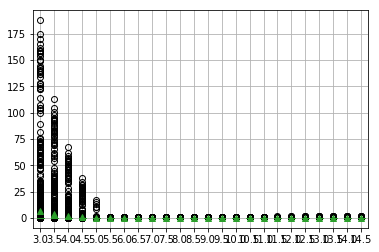

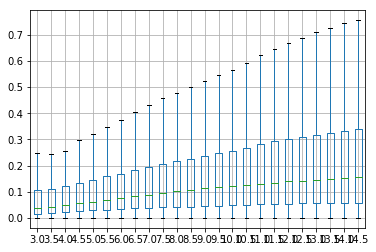

In [11]:
plt.subplots()
plt.figure(1)
df.T.boxplot(showmeans=True)
plt.figure(2)
df.T.boxplot(showfliers=False)
plt.show()

In [12]:
df2=pd.DataFrame(times,index=forces)
df2.T.describe()

,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,...,10.0,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5
count,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,...,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000
mean,0.055269,-0.023570,-0.080470,-0.117134,-0.146502,-0.157016,-0.164284,-0.170747,-0.176484,-0.181791,...,-0.202498,-0.205873,-0.209056,-0.212065,-0.214917,-0.217625,-0.220203,-0.222661,-0.225009,-0.227254
std,0.431591,0.316103,0.225039,0.153084,0.080251,0.066455,0.064403,0.063258,0.062331,0.061691,...,0.058278,0.057700,0.057147,0.056616,0.056104,0.055611,0.055134,0.054672,0.054225,0.053792
min,-0.339533,-0.341411,-0.343091,-0.349130,-0.352787,-0.355259,-0.357142,-0.358670,-0.359960,-0.361079,...,-0.365170,-0.365798,-0.366383,-0.366931,-0.367446,-0.367932,-0.368391,-0.368827,-0.369564,-0.370299
25%,-0.155082,-0.169813,-0.181477,-0.190341,-0.198190,-0.205497,-0.211856,-0.217714,-0.222730,-0.227430,...,-0.245283,-0.247969,-0.250599,-0.253435,-0.255942,-0.258461,-0.260604,-0.262811,-0.264929,-0.266684
50%,-0.093348,-0.111062,-0.124841,-0.136507,-0.146079,-0.154649,-0.163325,-0.170598,-0.177134,-0.182000,...,-0.204708,-0.207980,-0.211202,-0.214094,-0.217102,-0.220130,-0.222837,-0.225303,-0.227576,-0.230030
75%,-0.015947,-0.045457,-0.070056,-0.085613,-0.099016,-0.109107,-0.116584,-0.123832,-0.129362,-0.135091,...,-0.157535,-0.161174,-0.164528,-0.168250,-0.171695,-0.174631,-0.177775,-0.180629,-0.183281,-0.186268
max,1.799531,1.394079,1.076804,0.809368,0.544507,0.159757,0.040541,-0.004616,-0.029421,-0.042282,...,-0.077364,-0.083119,-0.088551,-0.093690,-0.098562,-0.103190,-0.107594,-0.111793,-0.115803,-0.119637


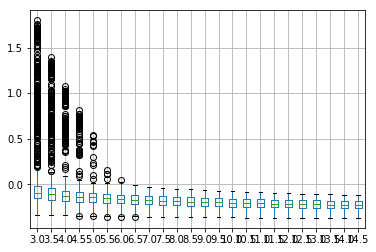

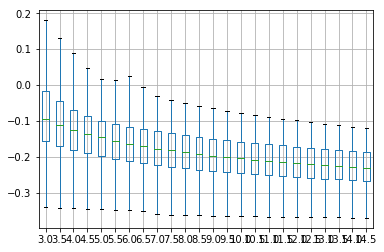

In [13]:
plt.subplots()
plt.figure(1)
df2.T.boxplot()
plt.figure(2)
df2.T.boxplot(showfliers=False)
plt.show()

In [46]:
def path_bis(a,b,v,tf,nb_points=100):
    Fx=2*(b[0]-a[0]-v[0]*tf)/tf**2
    Fy=2*(b[1]-a[1]-v[1]*tf)/tf**2
    dt=tf/nb_points
    t=dt
    lx=[a[0]]
    ly=[a[1]]
    for i in range(nb_points):
        x=a[0]+v[0]*t+Fx*t**2/2
        y=a[1]+v[1]*t+Fy*t**2/2
        lx.append(x)
        ly.append(y)
        t=t+dt
    return [lx,ly,Fx,Fy]

In [57]:
def event_trajectory_error_bis(eventId,t):
    event=events[eventId]
    moments=event['moments']
    forces=[]
    error=[]
        
    for mom_id in range(len(moments)-round(t/0.04)-1):
        moment1=moments[mom_id][5]
        moment2=moments[mom_id+1][5]
        moment1f=moments[mom_id+round(t/0.04)][5]
        moment2f=moments[mom_id+round(t/0.04)+1][5]
        mom_infos=players_ball_speed_position(moment1,moment2)
        mom_infos_final=players_ball_speed_position(moment1f,moment2f)
        LX={}
        LY={}
        LXREAL={}
        LYREAL={}
        
        for player in mom_infos['team1'].keys():
            a=mom_infos['team1'][player]['xy']
            v=mom_infos['team1'][player]['v']
            b=mom_infos_final['team1'][player]['xy']
            lx,ly,Fx,Fy=path_bis(a,b,v,t,round(t/0.04))
            forces.append(np.linalg.norm(np.array([Fx,Fy])))
            LX[player]=lx
            LY[player]=ly
            
        for player in mom_infos['team2'].keys():
            a=mom_infos['team2'][player]['xy']
            v=mom_infos['team2'][player]['v']
            b=mom_infos_final['team2'][player]['xy']
            lx,ly,Fx,Fy=path_bis(a,b,v,t,round(t/0.04))
            forces.append(np.linalg.norm(np.array([Fx,Fy])))
            LX[player]=lx
            LY[player]=ly
            
        for player in mom_infos['team1'].keys():
            LXREAL[player]=[]
            LYREAL[player]=[]
            
        for player in mom_infos['team2'].keys():
            LXREAL[player]=[]
            LYREAL[player]=[]
            
        for i in range(round(t/0.04)+1):
            mom1=moments[mom_id+i][5]
            mom2=moments[mom_id+i+1][5]
            mom_infos=players_ball_speed_position(mom1,mom2)
            for player in mom_infos['team1'].keys():
                LXREAL[player].append(mom_infos['team1'][player]['xy'][0])
                LYREAL[player].append(mom_infos['team1'][player]['xy'][1])
                
            for player in mom_infos['team2'].keys():
                LXREAL[player]=LXREAL[player]+[mom_infos['team2'][player]['xy'][0]]
                LYREAL[player]=LYREAL[player]+[mom_infos['team2'][player]['xy'][1]]
        
        for player in LX.keys():
            if one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player])>0.2:
                print(LX[player][-1],LXREAL[player][-1])
                print(one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player]))
                plt.plot(LX[player],LY[player],'b--')
                plt.plot(LXREAL[player],LYREAL[player],'r-')
                plt.show()
            error.append(one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player]))
            
    error=pd.DataFrame(error)
    forces=pd.DataFrame(forces)
    return(error,forces)

14.81241 14.81241
0.316006415494


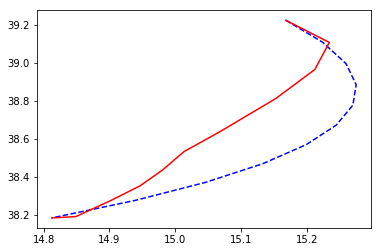

14.01986 14.01986
0.259797100203


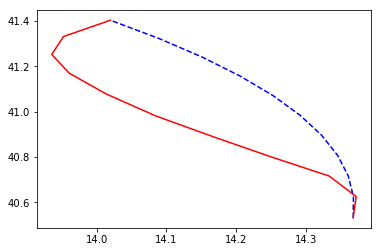

14.09876 14.09876
0.213286745741


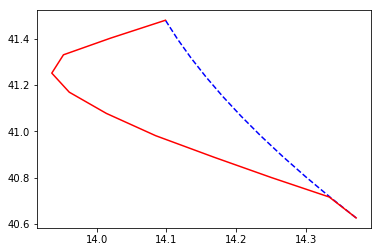

4.16391 4.16391
0.316482620725


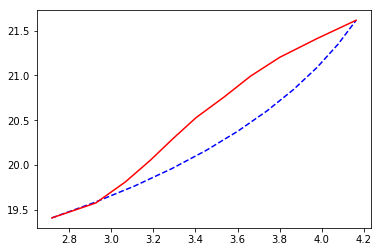

In [58]:
error,forces=event_trajectory_error_bis(0,0.4)

In [55]:
forces.describe()

,0
count,1390.000000
mean,5.074167
std,3.312939
min,0.206945
25%,2.552628
50%,4.504134
75%,6.859761
max,21.039982


In [56]:
error.describe()

,0
count,1390.000000
mean,0.014380
std,0.026299
min,0.000037
25%,0.002259
50%,0.006018
75%,0.013788
max,0.316483


## Sources 
[1] Akira Fujimura and Kokichi Sugihara. Geo- metric analysis and quantitative evaluation of sport teamwork. *Systems and Computers in Japan*, 36(6):49–58, 2005.